Nicholas O'Mahony - 21353123
Brendan Swords - 21323615

The code executes to the end without error.

Sources:
https://scikit-learn.org/1.5/modules/neural_networks_supervised.html


#Imports

In [ ]:
# Data manipulation and CSV handling
import pandas as pd
import csv

# Preprocessing and transformers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# General utilities and metrics
import numpy as np
from numpy import mean, std
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import get_ipython
from IPython.display import display

#The data set
We chose the laptop prices data set from the following link: https://www.kaggle.com/datasets/owm4096/laptop-prices?resource=download

The data set contains 23 columns, examples are CPU frequency, CPU brand name, laptop brand, screen size, ram, storage details, GPU details, laptop weight and more. We chose to use a MLP regression model to predict the price of a laptop based on the attributes of the *laptops*. All visualisations and graphs can be found at the end of this file.

In [ ]:
class LaptopPriceDataset:
    def __init__(self, file_path):
        # Load the dataset
        self.raw = pd.read_csv(file_path)

        self.raw['Company_TypeName'] = self.raw['Company'] + '_' + self.raw['TypeName']
        self.raw['ScreenArea'] = self.raw['ScreenW'] * self.raw['ScreenH']

        # Set the categorical and numeric columns
        self.cols = ['Inches', 'Ram', 'OS', 'Weight', 'ScreenArea',
                     'Touchscreen', 'IPSpanel', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage',
                     'GPU_company', 'GPU_model', 'Company_TypeName', 'Screen', 'RetinaDisplay',
                     'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType']


        # Define the target (Price_euros)
        self.y = self.raw['Price_euros']

        # Apply log to price, to scale down the large number outlier and expand the lower values
        self.y = np.log1p(self.y)

        # Create a scaler for prices
        self.price_scaler = MinMaxScaler()

        # MinMaxScaler takes a 2 dimensional array of prices, we reshape our prices into a 2D array, apply the scaling using MinMaxScaler,
        # and then use .flatten() to turn it back into a 1D array
        self.y_scaled = self.price_scaler.fit_transform(self.y.values.reshape(-1, 1)).flatten()

        # Assign columns from self.cols to self.X for processing
        self.X = self.raw[self.cols]

        # use the preprocessing function on the data
        self.preprocess()

    def preprocess(self):
        # Remove duplicates
        self.raw.drop_duplicates(inplace=True)

        # Separating numerical and categorical columns
        numeric_cols = ['Inches', 'Ram', 'Weight', 'ScreenArea', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage']
        categorical_cols = ['OS', 'Touchscreen', 'IPSpanel', 'GPU_company', 'GPU_model', 'Company_TypeName', 'RetinaDisplay',
                     'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType','Screen']

        # One-hot encode the categorical features and normalize the numerical ones
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), numeric_cols),  # Normalize numeric data
                ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical data
            ])

        # Apply transformations
        self.X = preprocessor.fit_transform(self.X)

    def print(self):
        print("Sample target (y):", self.y_scaled[0:5])

file_path = '../content/sample_data/laptop_prices.csv'
data = LaptopPriceDataset(file_path)
data.print()

Sample target (y): [0.57336123 0.46111606 0.33546469 0.75311985 0.65703709]



self.raw['Company_TypeName'] = self.raw['Company'] + '_' + self.raw['TypeName']
This line combines 2 columns, Company and TypeName into one, Company_TypeName

self.raw['ScreenArea'] = self.raw['ScreenW'] * self.raw['ScreenH']
This does the same to create Screen Area

        # Update categorical_cols
        self.cols = ['Inches', 'Ram', 'OS', 'Weight', 'ScreenArea',
                     'Touchscreen', 'IPSpanel', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage',
                     'GPU_company', 'GPU_model', 'Company_TypeName', 'Screen', 'RetinaDisplay',
                     'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType']
Specifies the columns we use for predicting the laptop prices
        categorical_cols = ['OS', 'Touchscreen', 'IPSpanel', 'GPU_company', 'GPU_model', 'Company_TypeName', 'RetinaDisplay', 'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType', 'Screen']
Lists which columns contain categorical data, must be OneHotEncoded before use
        numeric_cols = ['Inches', 'Ram', 'Weight', 'ScreenArea', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage']
Lists the numeric columns
        # Define the target (Price_euros)
        self.y = self.raw['Price_euros']
Sets the target to be price

        # Apply log to price, to scale down the large number outlier and expand the lower values
        self.y = np.log1p(self.y)
The data is heavily skewed to the right, meaning there are many more low/mid range prices than expensive. We noticed a large improvement by logging the price so that the upper-end laptop predictions were much more consistent

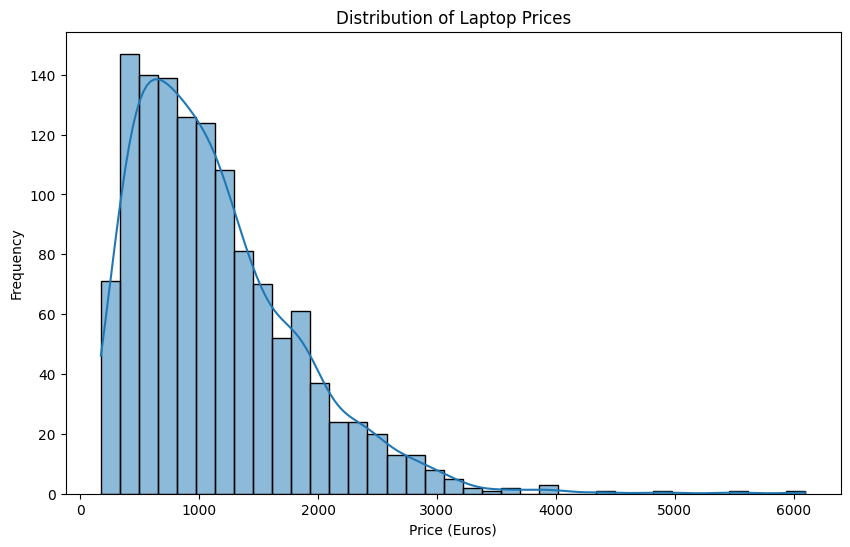

In [ ]:
# Distribution of laptop prices
plt.figure(figsize=(10, 6))
sns.histplot(data.raw['Price_euros'], kde=True) #kde is the smooth curve overlaid on the histogram
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price (Euros)')
plt.ylabel('Frequency')
plt.show()

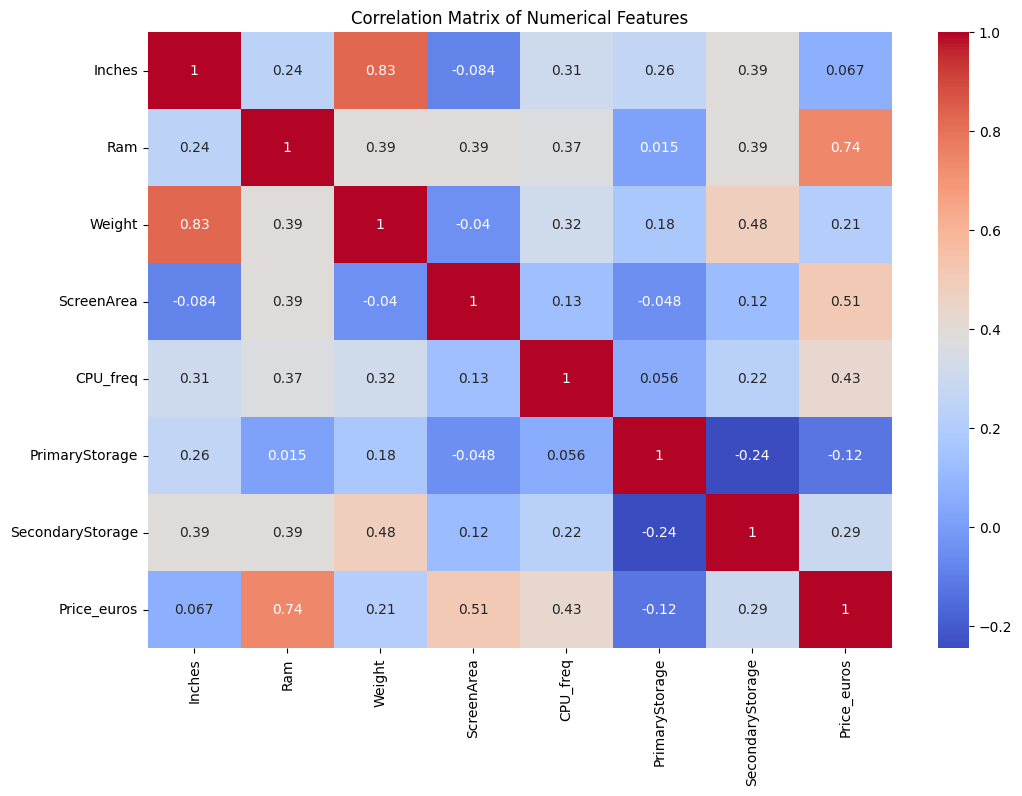

In [ ]:
# Correlation matrix of numerical features
numerical_features = ['Inches', 'Ram', 'Weight', 'ScreenArea', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage', 'Price_euros' ]
correlation_matrix = data.raw[numerical_features].corr()
#uses our dataset cols, .corr is the padas method to calculate correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Splits the dataset into training and validation and testing sets.
# Sets 20% for testing
# random_state set as 1 makes it reproducible
X_train_val, X_test, y_train_val, y_test = train_test_split(data.X, data.y_scaled, test_size=0.2, random_state=1)

# Split the training and validation set into separate training and validation sets.
# 25% of the training and validation data is allocated to validation.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

# Network structure and other hyperparameters

The model we use is the MLP regressor model from SciKit: https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html

There are 4 hidden layers with 100,25,25, and 25 neurons respectively. We found this configuration to output the highest scores while tuning the hyperparameters and found it reduced overfitting.

The activation we use is relu as we are performing regression.

**Hyperparameters:**

The model can iterate a maximum of 1000 epochs.

We set random_state to 1 so we can reproduce the same results by initialising the model with the same random seed.

The inital learning rate is set to 0.0005, which is low, but as we are repeating a max of 10,000 times, this allows the model to learn gradually.

Alpha is set as 0.1 to prevent overfitting and 0.1 was the most efficient value after tuning parameters.

The MLPRegressor model from SciKit uses the mean squared error (MSE) as its default loss function and we inherintly use it in blocks of code such as clf.fit(X_train, y_train) and clf.partial_fit(X_train, y_train).

MSE calculates the average squared differnece between the predicted laptop prices and the actual prices.

The optimiser we use is Adam. This optimiser adapts learning rates for faster convergence.

In [ ]:
# Classifier is MLPRegressor, this is to use regression to predict a single value (our laptop prices)
clf = MLPRegressor(
    random_state=1,
    solver='adam',
    max_iter=1000,
    hidden_layer_sizes=[100, 25, 25, 25],
    activation='relu',
    learning_rate_init=0.0005,
    alpha=0.1
).fit(X_train, y_train) # Call the fit method from our MLPRegressor clf. This trains the model by adjusting weights and biases to more accurately predict prices.
prob = clf.predict(X_test[:1])


# Loss values
training_losses = []

for epoch in range(500):
    clf.partial_fit(X_train, y_train) # take a portion of the dataset and repeatedly train for 500 epochs to calculate training loss
    loss = clf.loss_
    training_losses.append(loss)

# makes predictions
predict = clf.predict(X_test)

# Using R^2 score to evaluate how good a fit the model is for the data
score = r2_score(y_test, predict)

print(f"Score {score}")

Score 0.893218538932597


#Model evaluation

For evaluation of the model, we use R^2, evaluating between 0 and 1. 0 meaning the model is unfit to predict on the training set, 1 being it is perfectly fir to predict prices on the training set.

We also calculate the root mean squared error and its standard deviation and the mean absolute percentage error to show how far the average prediction is from the actual target.

Full evaluation can be found at the bottom of this file.


Cross fold validation:
In the below code we perform cross-validation to evaluate the model on how it performs on unseen data. We split the data into 10, shuffle it and then train and evaluate. This is neccesary to ensure our model isn't overfitting and generalizing to only be good at the data it is trained on, but instead can perform well on unseen data.

#Results

Mean RMSE: 0.056
Standard Deviation of RMSE: 0.006


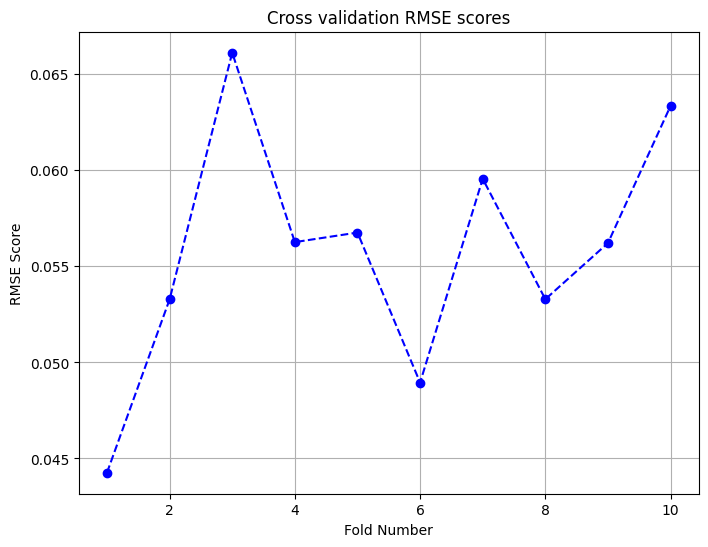

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
#creates a KFold object for cross validation
#splits it in 10, shuffles it and set random_state to 1 for consistent results
scores = cross_val_score(clf, data.X, data.y_scaled, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
#Performs cross validation using clf data and the kfold object
#scoring uses negetive mean squared error as an evaluation metric
#n_jobs=-1 tells it to use all available CPU cores
rmse_scores = np.sqrt(-scores)  # Convert negative MSE scores to RMSE
print(f"Mean RMSE: {np.mean(rmse_scores):.3f}")
print(f"Standard Deviation of RMSE: {np.std(rmse_scores):.3f}")

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o', linestyle='--', color='b')
plt.title('Cross validation RMSE scores')
plt.xlabel('Fold Number')
plt.ylabel('RMSE Score')
plt.grid(True)
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(y_test, predict)
#calculates MAPE between actual value and predicted
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

Mean Absolute Percentage Error (MAPE): 0.11


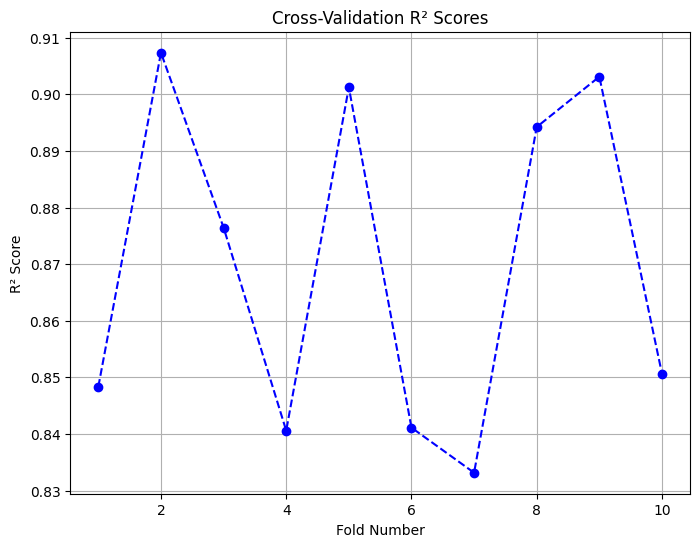

Mean R² score: 0.870
Standard Deviation of R² score: 0.028


In [ ]:
#Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Cross-validation with R^2 score
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation R² Scores')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

print(f'Mean R² score: {np.mean(cv_scores):.3f}')
print(f'Standard Deviation of R² score: {np.std(cv_scores):.3f}')


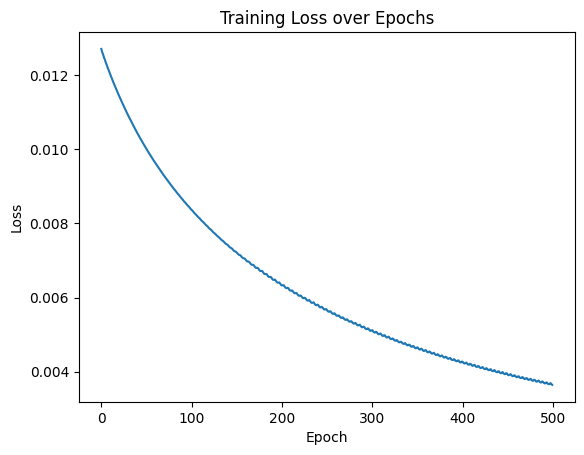

In [ ]:
# Plot training loss over epochs
plt.plot(training_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

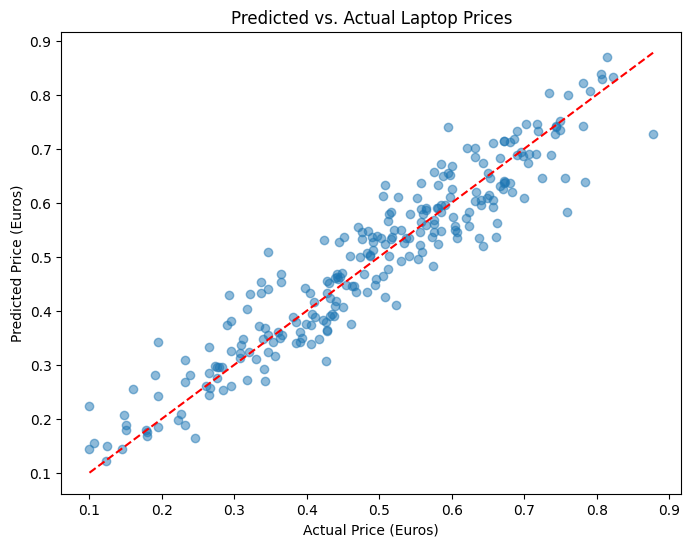

In [ ]:
# Scatter plot of predicted vs. actual prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predict, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
#min(y_test),max(y_test) defines the x coords, then predicts the y coords, sets line colour and style
plt.title('Predicted vs. Actual Laptop Prices')
plt.xlabel('Actual Price (Euros)')
plt.ylabel('Predicted Price (Euros)')
plt.show()

#Evaluation of the model results

As seen in the predicted vs actual price of laptop graph above, the model can consistently and accurately predict the prices of laptops based on the specifications of the laptop.

The R^2 score on unseen data performs returns Mean R² score: 0.870 and on training data it is 0.89. This score shows us that on average, 87% of the variance of prices of laptops from unseen data can be explained by the model.

The root mean squared error is 0.056. This means that the error in predicting laptop prices is approximately 0.056 in our scaled price units (which range between 0 and 1).

The standard deviation of our RMSE is 0.006, meaning that between folds it performs consistently and can handle unseen data well.

Another metric we used is the Mean Absolute Percentage Error (MAPE)

MAPE returned a result of 0.11, showing that on average our model is 11% away from the scaled target price of the laptop when making predictions.

#Impact of varying a hyperparameter
An interesting observation is shown below. When changing our hidden layers from [100, 25, 25, 25] to [100], it slightly increases the accuracy of the test score from 0.893 to 0.896, however when performing kfold cross validation, it performs significantly worse. The kfold score goes from 0.818 to 0.753.

This is most likely due to the reduction in hidden layers causing overfitting, increasing the test score but then performing worse on unseen data.

n.b. this code is commented out so it does not run by mistake when performing actual tests.

In [ ]:
# # Example showing the change in hyperparameters causing impact to k fold

# clf = MLPRegressor(
#     random_state=1,
#     solver='adam',
#     max_iter=1000,
#     hidden_layer_sizes=[100],
#     activation='relu',
#     learning_rate_init=0.0005,
#     alpha=0.1
# ).fit(X_train, y_train)
# prob = clf.predict(X_test[:1])


# training_losses = []

# for epoch in range(500):
#     clf.partial_fit(X_train, y_train) # Removed classes parameter as it is not needed for regression
#     loss = clf.loss_
#     training_losses.append(loss)

# predict = clf.predict(X_test)

# score = r2_score(y_test, predict)


# print(f"Score {score}")

# kf = KFold(n_splits=10, shuffle=True, random_state=1)

# scores = cross_val_score(clf, X_test, y_test, scoring='r2', cv=kf, n_jobs=-1)
# print('R-squared: %.3f (%.3f)' % (mean(scores), std(scores)))

# results:
# Score 0.896641130778989
# R-squared: 0.753 (0.047)